In [1]:
import pandas as pd

In [2]:
TU_objects_df = pd.read_csv(
    "./data/RegulonDB10/tu_objects_tmp.txt",
    sep="\t",
    comment='#',
    header=None,
)

TU_objects_df.columns = [
    "TRANSCRIPTION_UNIT_ID",
    "NUMTU",
    "TU_POSLEFT",
    "TU_POSRIGHT",
    "TU_TYPE",
    "TU_OBJECT_CLASS",
    "TU_OBJECT_ID",
    "TU_OBJECT_NAME",
    "TU_OBJECT_POSLEFT",
    "TU_OBJECT_POSRIGHT",
    "TU_OBJECT_STRAND",
    "TU_OBJECT_COLORCLASS",
    "TU_OBJECT_DESCRIPTION",
    "TU_OBJECT_SIGMA",
    "TU_OBJECT_EVIDENCE",
    "TU_OBJECT_RI_TYPE",
    "TU_OBJECT_TYPE",
    "EVIDENCE"
]
TU_objects_df.head()

,TRANSCRIPTION_UNIT_ID,NUMTU,TU_POSLEFT,TU_POSRIGHT,TU_TYPE,TU_OBJECT_CLASS,TU_OBJECT_ID,TU_OBJECT_NAME,TU_OBJECT_POSLEFT,TU_OBJECT_POSRIGHT,TU_OBJECT_STRAND,TU_OBJECT_COLORCLASS,TU_OBJECT_DESCRIPTION,TU_OBJECT_SIGMA,TU_OBJECT_EVIDENCE,TU_OBJECT_RI_TYPE,TU_OBJECT_TYPE,EVIDENCE
0,ECK120008913,3,1825955,1832013,H,PM,ECK120009851,astCp1,1832013,1832013,R,NaN,NaN,Sigma70,Human inference of promoter position,NaN,predicted,NaN
1,ECK120008913,3,1825955,1832013,H,GN,ECK120003528,astE,1825955,1826923,R,"51,153,255",amino acids,NaN,NaN,NaN,predicted,NaN
2,ECK120008913,3,1825955,1832013,H,GN,ECK120003529,astB,1826916,1828259,R,"51,153,255",amino acids,NaN,NaN,NaN,predicted,NaN
3,ECK120008913,3,1825955,1832013,H,GN,ECK120003532,astC,1830762,1831982,R,"0,0,255",nitrogen metabolism,NaN,NaN,NaN,predicted,NaN
4,ECK120008913,3,1825955,1832013,H,GN,ECK120003530,astD,1828256,1829734,R,"51,153,255",amino acids,NaN,NaN,NaN,predicted,NaN


In [3]:
regulon_df = TU_objects_df[TU_objects_df["TU_OBJECT_CLASS"]=="ST"].copy()
regulon_df = regulon_df.drop(
    columns=['NUMTU',
             'TU_TYPE',
             'TU_OBJECT_ID',
             'TU_OBJECT_POSLEFT',
             'TU_OBJECT_POSRIGHT',
             'TU_OBJECT_STRAND',
             'TU_OBJECT_COLORCLASS',
             'TU_OBJECT_DESCRIPTION',
             'TU_OBJECT_SIGMA',
             'TU_OBJECT_EVIDENCE',
             'TU_OBJECT_RI_TYPE',
             'TU_OBJECT_TYPE',
             'EVIDENCE']
)
regulon_df = regulon_df.drop_duplicates()
regulon_df["TU_LENGTH"] = regulon_df.apply(lambda row: row["TU_POSRIGHT"] - row["TU_POSLEFT"] + 1, axis=1)
regulon_df.head()

,TRANSCRIPTION_UNIT_ID,TU_POSLEFT,TU_POSRIGHT,TU_OBJECT_CLASS,TU_OBJECT_NAME,TU_LENGTH
12,ECK120008914,1825955,1832327,ST,ArgR,6373
15,ECK120008914,1825955,1832327,ST,NtrC,6373
52,ECK120008916,2800586,2804461,ST,NrdR,3876
53,ECK120008916,2800586,2804461,ST,IscR,3876
54,ECK120008916,2800586,2804461,ST,Fur,3876


In [4]:
def get_regulon_length(TF):
    reg_len = 0
    df = regulon_df[regulon_df["TU_OBJECT_NAME"].str.contains(TF)]
    if len(df) > 0:
        reg_len = df["TU_LENGTH"].sum()
    return reg_len


# TODO: same as in 11_regulon_convergence.ipynb. Extract into separate script file.
def get_clean_regulon_name_set(reg_str):
    clean_reg_name_set = set()
    if ',' in reg_str:
        clean_reg_name_set |= set(reg_str.split(','))
    else:
        clean_reg_name_set |= set([reg_str])
    return clean_reg_name_set


reg_len_df = pd.DataFrame()
reg_name_set = set()
for reg_str in regulon_df["TU_OBJECT_NAME"].unique():
    reg_name_set |= get_clean_regulon_name_set(reg_str)
for reg in reg_name_set:
    reg_len_df = reg_len_df.append({"transcription factor": reg}, ignore_index=True)
    

reg_len_df["regulon length"] = reg_len_df["transcription factor"].apply(get_regulon_length)
reg_len_df.head()

,transcription factor,regulon length
0,OxyR,43409
1,MelR,7436
2,AlaS,2734
3,ModE,58024
4,AllS,3253


In [5]:
# Could be faster
all_TU_pos_set = set()
for idx, tu_row in regulon_df.iterrows():
    tu_range = set(range(tu_row["TU_POSLEFT"], tu_row["TU_POSRIGHT"] + 1))
    all_TU_pos_set= all_TU_pos_set.union(tu_range)
display(len(all_TU_pos_set))

1965599

In [6]:
unknown_regulon_pos_set = set(range(1 ,4641653 + 1)).difference(all_TU_pos_set)
unknown_regulon_nuc_len = len(unknown_regulon_pos_set)
reg_len_df = reg_len_df.set_index("transcription factor")
reg_len_df.loc["unknown"]=unknown_regulon_nuc_len
reg_len_df.head()

,regulon length
transcription factor,
OxyR,43409
MelR,7436
AlaS,2734
ModE,58024
AllS,3253


In [7]:
reg_len_df.to_pickle("./data/regulon_len_df.pkl")

In [8]:
E_COLI_GENOME_LEN = 4641653
unknown_pos_set = set(range(1 ,E_COLI_GENOME_LEN+1)).difference(all_TU_pos_set)
unknown_nuc_len = len(unknown_pos_set)
regulon_genome_cov = 1-(unknown_nuc_len/E_COLI_GENOME_LEN)

import pickle
with open("./data/regulon_genome_coverage.pkl", 'wb') as f:
    pickle.dump(regulon_genome_cov, f)

(0, 1)

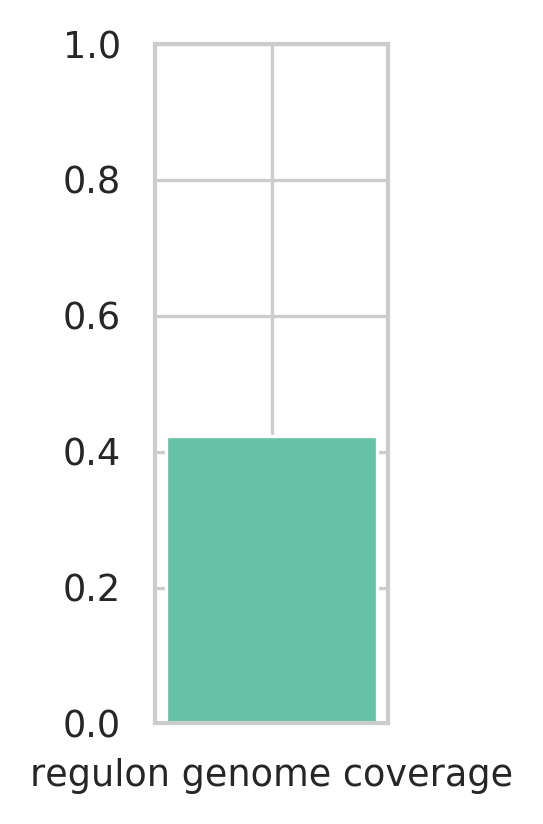

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.dpi"] = 300
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("Set2")


plt.figure(figsize=(1,3))
plt.bar('regulon genome coverage',
        regulon_genome_cov,
        width=[0.1]
       )
plt.ylim(0, 1)